<a href="https://colab.research.google.com/github/dD2405/Intro_to_TensorFlow/blob/master/4_Dogs_vs_Cats_Image_Classification_Without_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it?



# Importing Packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data






In [0]:
from __future__ import absolute_import, division, unicode_literals, print_function

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In previous Colabs, we've used <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a>, which is a very easy and convenient way to use datasets. In this Colab however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 0s 0us/step


In [8]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


We'll now assign variables with the proper file path for the training and validation sets.

In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [12]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("------------------------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
------------------------------------------------------------------
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [0]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

# Plotting the image

This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.




In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(15,15))
    axes = axes.flatten()
    
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

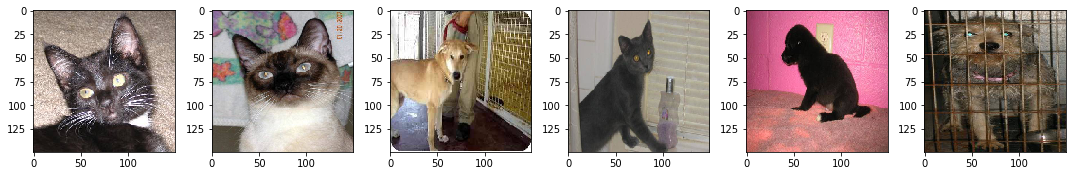

In [32]:
plotImages(sample_training_images[:6])